# Gradient Boosting with CatBoost

Dataset Amazon Employee Access Challenge from [Here](https://www.kaggle.com/c/amazon-employee-access-challenge/data) challenge.

## Libraries installation

In [1]:
!pip install --upgrade catboost
!pip install --upgrade ipywidgets
!pip install shap
!pip install scikit-learn
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import catboost
print(catboost.__version__)

1.2.7


## Reading the data

In [3]:
from catboost.datasets import amazon

# If you have "URLError: SSL: CERTIFICATE_VERIFY_FAILED" uncomment next two lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# If you have any other error:
# Download datasets from http://bit.ly/2ZUXTSv and uncomment next line:
# train_df = pd.read_csv('train.csv', sep=',', header='infer')

(train_df, test_df) = amazon()

In [4]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Exploring the data

Label values extraction

In [5]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [6]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [7]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


# Training the first model

In [8]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100)
model.fit(X, y, cat_features=cat_features, verbose=10)

Learning rate set to 0.377604
0:	learn: 0.4528598	total: 65.1ms	remaining: 6.45s
10:	learn: 0.1744186	total: 101ms	remaining: 818ms
20:	learn: 0.1676119	total: 142ms	remaining: 533ms
30:	learn: 0.1652446	total: 180ms	remaining: 401ms
40:	learn: 0.1633644	total: 223ms	remaining: 320ms
50:	learn: 0.1621892	total: 263ms	remaining: 252ms
60:	learn: 0.1609164	total: 302ms	remaining: 193ms
70:	learn: 0.1594572	total: 342ms	remaining: 140ms
80:	learn: 0.1585876	total: 382ms	remaining: 89.6ms
90:	learn: 0.1573593	total: 421ms	remaining: 41.6ms
99:	learn: 0.1566977	total: 458ms	remaining: 0us


In [9]:
model.predict_proba(X)

array([[0.0098, 0.9902],
       [0.0101, 0.9899],
       [0.0579, 0.9421],
       ...,
       [0.0118, 0.9882],
       [0.1891, 0.8109],
       [0.0235, 0.9765]])

# Working with dataset

There are several ways of passing dataset to training - using X,y (the initial matrix) or using Pool class.
Pool class is the class for storing the dataset. In the next few blocks we'll explore the ways to create a Pool object.

You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [10]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

## Split your data into train and validation

In [11]:
from sklearn.model_selection import train_test_split

data = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_validation,
    label=y_validation,
    cat_features=cat_features
)

## Selecting the objective function

Possible options for binary classification:

`Logloss` for binary target.

`CrossEntropy` for probabilities in target.

In [12]:
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


## Stdout of the training

In [13]:
model = CatBoostClassifier(
    iterations=50,
#     verbose=5,
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.26136
0:	learn: 0.5154456	test: 0.5149541	best: 0.5149541 (0)	total: 12.8ms	remaining: 627ms
1:	learn: 0.4118495	test: 0.4104973	best: 0.4104973 (1)	total: 29.4ms	remaining: 704ms
2:	learn: 0.3460031	test: 0.3442180	best: 0.3442180 (2)	total: 33.8ms	remaining: 530ms
3:	learn: 0.3024013	test: 0.3000144	best: 0.3000144 (3)	total: 40.2ms	remaining: 462ms
4:	learn: 0.2733081	test: 0.2704095	best: 0.2704095 (4)	total: 44.8ms	remaining: 403ms
5:	learn: 0.2509190	test: 0.2476243	best: 0.2476243 (5)	total: 50ms	remaining: 366ms
6:	learn: 0.2345403	test: 0.2307493	best: 0.2307493 (6)	total: 53.9ms	remaining: 331ms
7:	learn: 0.2179583	test: 0.2130768	best: 0.2130768 (7)	total: 58.6ms	remaining: 308ms
8:	learn: 0.2082293	test: 0.2026652	best: 0.2026652 (8)	total: 60.7ms	remaining: 277ms
9:	learn: 0.2002072	test: 0.1937624	best: 0.1937624 (9)	total: 65.4ms	remaining: 262ms
10:	learn: 0.1946935	test: 0.1875751	best: 0.1875751 (10)	total: 69.1ms	remaining: 245ms
11:	learn: 0.1

## Metrics calculation and graph plotting

In [14]:
model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [15]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    train_dir='learing_rate_0.01'
)

model1.fit(train_pool, eval_set=validation_pool, verbose=20)
model2.fit(train_pool, eval_set=validation_pool, verbose=20);

0:	learn: 0.3264513	test: 0.3248170	best: 0.3248170 (0)	total: 6.96ms	remaining: 689ms
20:	learn: 0.1688825	test: 0.1574182	best: 0.1573949 (16)	total: 125ms	remaining: 470ms
40:	learn: 0.1632884	test: 0.1582531	best: 0.1571533 (23)	total: 206ms	remaining: 296ms
60:	learn: 0.1584388	test: 0.1573279	best: 0.1569712 (52)	total: 287ms	remaining: 183ms
80:	learn: 0.1544315	test: 0.1583347	best: 0.1569712 (52)	total: 358ms	remaining: 83.9ms
99:	learn: 0.1510452	test: 0.1583594	best: 0.1569712 (52)	total: 425ms	remaining: 0us

bestTest = 0.1569712214
bestIteration = 52

Shrink model to first 53 iterations.
0:	learn: 0.6853769	test: 0.6853610	best: 0.6853610 (0)	total: 4.21ms	remaining: 417ms
20:	learn: 0.5575578	test: 0.5568257	best: 0.5568257 (20)	total: 67.1ms	remaining: 252ms
40:	learn: 0.4678112	test: 0.4663769	best: 0.4663769 (40)	total: 130ms	remaining: 188ms
60:	learn: 0.4029225	test: 0.4011544	best: 0.4011544 (60)	total: 183ms	remaining: 117ms
80:	learn: 0.3551621	test: 0.3530433	bes

In [16]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.7', 'learing_rate_0.01']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [17]:
model = CatBoostClassifier(
    iterations=100,
#     use_best_model=False
)
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


## Cross-validation

In [19]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1631730144
bestIteration = 21

Training on fold [1/5]

bestTest = 0.1608272543
bestIteration = 77

Training on fold [2/5]

bestTest = 0.1694535356
bestIteration = 12

Training on fold [3/5]

bestTest = 0.1585003229
bestIteration = 25

Training on fold [4/5]

bestTest = 0.1644437541
bestIteration = 30



In [20]:
cv_data.head(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.305831,0.000020,0.305810,0.000014,0.496175,0.014042
1,1,0.234755,0.001020,0.235427,0.000274,0.569789,0.030202
2,2,0.196036,0.002694,0.202469,0.003171,0.761543,0.025878
3,3,0.182480,0.001478,0.191187,0.001296,0.800445,0.006064
4,4,0.175592,0.001577,0.185457,0.002225,0.815950,0.008441
5,5,0.172438,0.002514,0.182730,0.002549,0.821973,0.006706
6,6,0.170594,0.001823,0.180579,0.002626,0.828218,0.006576
7,7,0.168868,0.001821,0.178366,0.002423,0.832591,0.009500
8,8,0.167960,0.001793,0.176814,0.002493,0.834640,0.010008
9,9,0.166762,0.002656,0.175166,0.002392,0.837153,0.011330


In [22]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1639±0.0045 on step 31


In [23]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.152063398
bestIteration = 59

Training on fold [1/5]

bestTest = 0.1702631343
bestIteration = 32

Training on fold [2/5]

bestTest = 0.1674635849
bestIteration = 34

Training on fold [3/5]

bestTest = 0.1504856282
bestIteration = 39

Training on fold [4/5]

bestTest = 0.1693370995
bestIteration = 41



In [24]:
best_value = cv_data['test-Logloss-mean'].min()
best_iter = cv_data['test-Logloss-mean'].values.argmin()

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, stratified: 0.1625±0.0098 on step 39


## Sklearn Grid Search

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostClassifier(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6923673	total: 4.39ms	remaining: 83.4ms
19:	learn: 0.6778431	total: 50.4ms	remaining: 0us
0:	learn: 0.6923682	total: 2.54ms	remaining: 48.2ms
19:	learn: 0.6778558	total: 36.6ms	remaining: 0us
0:	learn: 0.6923682	total: 2.89ms	remaining: 54.9ms
19:	learn: 0.6778568	total: 49.7ms	remaining: 0us
0:	learn: 0.6853838	total: 2.38ms	remaining: 45.1ms
19:	learn: 0.5629769	total: 42.8ms	remaining: 0us
0:	learn: 0.6853928	total: 2.63ms	remaining: 50ms
19:	learn: 0.5630657	total: 35.5ms	remaining: 0us
0:	learn: 0.6853925	total: 2.3ms	remaining: 43.8ms
19:	learn: 0.5630556	total: 37ms	remaining: 0us
0:	learn: 0.3972934	total: 2.47ms	remaining: 47ms
19:	learn: 0.1766459	total: 53ms	remaining: 0us
0:	learn: 0.3977266	total: 2.8ms	remaining: 53.2ms
19:	learn: 0.1774892	total: 67ms	remaining: 0us
0:	learn: 0.3977128	total: 2.7ms	remaining: 51.3ms
19:	learn: 0.1733642	total: 55.7ms	remaining: 0us
0:	learn: 0.3971379	total: 4.36ms	remaining: 82.8ms
19:	learn: 0.1717590	total: 75.5ms	remainin

{'iterations': 20,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'learning_rate': 0.5}

## Overfitting Detector

In [27]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
print(model_with_early_stop.tree_count_)

20


### Overfitting Detector with eval metric

In [30]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
print(model_with_early_stop.tree_count_)

47


## Model predictions

In [32]:
model = CatBoostClassifier(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50);

0:	learn: 0.6569432	total: 16.1ms	remaining: 3.21s
50:	learn: 0.1950236	total: 475ms	remaining: 1.39s
100:	learn: 0.1660897	total: 1.07s	remaining: 1.04s
150:	learn: 0.1591440	total: 1.72s	remaining: 558ms
199:	learn: 0.1553100	total: 2.35s	remaining: 0us


In [33]:
print(model.predict(X_validation))

[1 1 1 ... 1 1 1]


In [34]:
print(model.predict_proba(X_validation))

[[0.0294 0.9706]
 [0.0188 0.9812]
 [0.0103 0.9897]
 ...
 [0.0296 0.9704]
 [0.0487 0.9513]
 [0.0204 0.9796]]


In [35]:
raw_pred = model.predict(
    X_validation,
    prediction_type='RawFormulaVal'
)

print(raw_pred)

[3.4958 3.9557 4.5654 ... 3.4891 2.9731 3.8709]


In [36]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9706 0.9812 0.9897 ... 0.9704 0.9513 0.9796]


## Select decision boundary

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [38]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

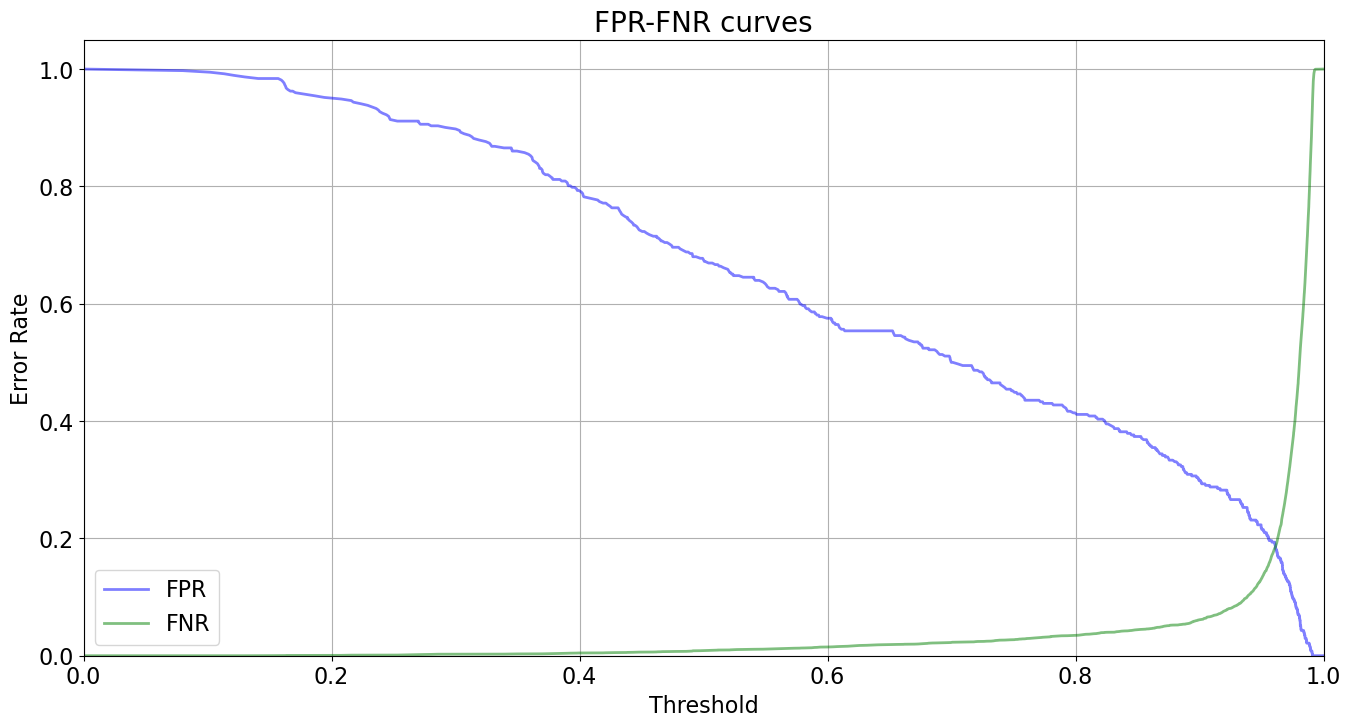

In [39]:
plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [40]:
from catboost.utils import select_threshold

print(select_threshold(model, validation_pool, FNR=0.01))
print(select_threshold(model, validation_pool, FPR=0.01))

0.5211490981065605
0.9897883751647973


## Metric evaluation on a new dataset

In [41]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [42]:
len(metrics['AUC'])

200

In [43]:
print('AUC values:\n{}'.format(np.array(metrics['AUC'])))

AUC values:
[0.5509 0.6273 0.6273 0.6279 0.6264 0.6262 0.6579 0.6579 0.6569 0.6568
 0.6567 0.6567 0.6556 0.6556 0.6556 0.6557 0.6558 0.6575 0.6587 0.6585
 0.6674 0.6804 0.7017 0.7101 0.7257 0.7307 0.7366 0.7439 0.7461 0.7513
 0.7599 0.7631 0.7631 0.7859 0.7958 0.8045 0.811  0.8141 0.8172 0.8246
 0.8274 0.8314 0.8378 0.8398 0.8437 0.8454 0.8468 0.8472 0.8476 0.8477
 0.8479 0.8492 0.8492 0.8512 0.8514 0.8515 0.8518 0.8523 0.8528 0.8528
 0.8529 0.8526 0.853  0.8534 0.8539 0.854  0.8538 0.8534 0.8533 0.8534
 0.8536 0.8538 0.8543 0.8546 0.8546 0.8546 0.8544 0.8544 0.8547 0.8581
 0.8615 0.8639 0.8659 0.868  0.8696 0.8711 0.8724 0.8735 0.8742 0.8749
 0.8752 0.8758 0.8759 0.8763 0.8769 0.8772 0.8775 0.8777 0.8781 0.8786
 0.879  0.8792 0.8794 0.8796 0.8798 0.88   0.8802 0.8804 0.8805 0.8808
 0.8807 0.8817 0.8827 0.8832 0.8838 0.8846 0.8851 0.8849 0.8854 0.8857
 0.8861 0.8865 0.8869 0.8869 0.8871 0.8874 0.8877 0.8881 0.8881 0.8881
 0.8884 0.8885 0.8888 0.889  0.889  0.8891 0.8893 0.8893 0.8895 0

## Feature importances

### Prediction values change

Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes.
These feature importances are non negative.
They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [44]:
np.array(model.get_feature_importance(prettified=True))

array([['RESOURCE', 21.151377366225915],
       ['ROLE_DEPTNAME', 16.186627305300313],
       ['MGR_ID', 16.173945097204474],
       ['ROLE_ROLLUP_2', 12.686326980844818],
       ['ROLE_TITLE', 11.966916713616056],
       ['ROLE_FAMILY_DESC', 9.612545494227621],
       ['ROLE_FAMILY', 7.721843702864999],
       ['ROLE_ROLLUP_1', 2.7267332780672118],
       ['ROLE_CODE', 1.773684061648586]], dtype=object)

### Loss function change

The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes.
This importances might be negative if the feature has bad influence on the loss function.
The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value.
To calculate this importance value you need to pass train_pool as an argument.

In [45]:
np.array(model.get_feature_importance(
    data=train_pool,
    type='LossFunctionChange',
    prettified=True
))

array([['RESOURCE', 0.02065299157550874],
       ['MGR_ID', 0.01743512867742089],
       ['ROLE_TITLE', 0.010781768912592658],
       ['ROLE_DEPTNAME', 0.008732318886081985],
       ['ROLE_FAMILY_DESC', 0.008207406982855487],
       ['ROLE_ROLLUP_2', 0.0069015523816554625],
       ['ROLE_FAMILY', 0.001204571799861949],
       ['ROLE_CODE', 0.0007858884702851288],
       ['ROLE_ROLLUP_1', 0.00013453289596478357]], dtype=object)

### Shap values

In [46]:
print(model.predict_proba([X.iloc[1,:]]))
print(model.predict_proba([X.iloc[91,:]]))

[[0.0102 0.9898]]
[[0.4897 0.5103]]


In [47]:
shap_values = model.get_feature_importance(
    data=validation_pool,
    type='ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(6554, 9)


In [48]:
proba = model.predict_proba([X_validation.iloc[1,:]])[0]
raw = model.predict([X_validation.iloc[1,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [0.0188 0.9812]
Raw formula value 3.9557
Probability from raw value 0.9812


In [49]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_validation.iloc[1,:])

In [50]:
proba = model.predict_proba([X_validation.iloc[91,:]])[0]
raw = model.predict([X_validation.iloc[91,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [0.0459 0.9541]
Raw formula value 3.0338
Probability from raw value 0.9541


In [51]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X_validation.iloc[91,:])

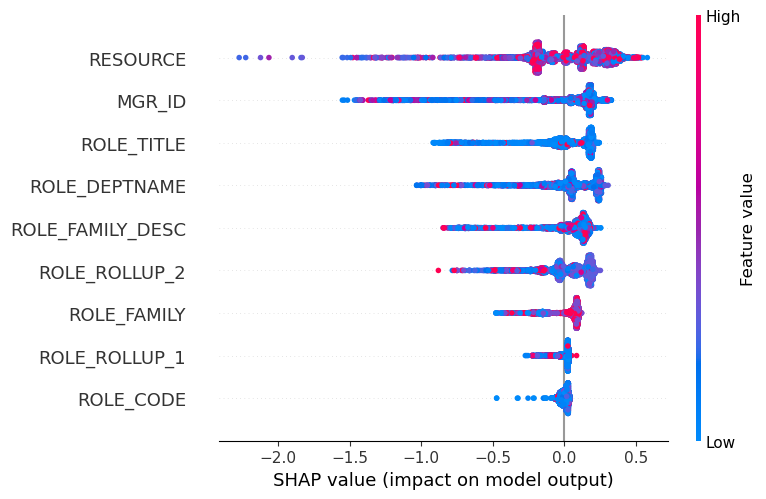

In [52]:
shap.summary_plot(shap_values, X_validation)

## Snapshotting

In [57]:
#!rm 'catboost_info/snapshot.bkp'

model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1
)

model.fit(train_pool, eval_set=validation_pool, verbose=10);

Learning rate set to 0.193326

bestTest = 0.1573067324
bestIteration = 81

Shrink model to first 82 iterations.


## Saving the model

In [54]:
model = CatBoostClassifier(iterations=10)
model.fit(train_pool, eval_set=validation_pool, verbose=False)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

In [55]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0.5


## Hyperparameter tunning

In [58]:
tunned_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
)

tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Speeding up the training

In [59]:
fast_model = CatBoostClassifier(
    boosting_type='Plain',
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.3,
    bootstrap_type='Bernoulli',
    subsample=0.5
)
fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Reducing model size

In [60]:
small_model = CatBoostClassifier(
    learning_rate=0.03,
    iterations=500,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
)
small_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))